IMPORTING PACKAGES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import ks_2samp
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_ccf

IMPORTING DATASET

In [13]:
# Import the dataset
dataset = pd.read_csv('device_data.csv')
print(dataset.head())

          hostname                 ifname             timeslot  \
0  nl-xy-switch-01  GigabitEthernet10/0/2  2025-06-19 13:00:00   
1  nl-xy-switch-01  GigabitEthernet10/0/2  2025-06-19 14:00:00   
2  nl-xy-switch-01  GigabitEthernet10/0/2  2025-06-19 15:00:00   
3  nl-xy-switch-01  GigabitEthernet10/0/2  2025-06-19 16:00:00   
4  nl-xy-switch-01  GigabitEthernet10/0/2  2025-06-19 17:00:00   

   max_metric_value  mean_metric_value  
0      5.665394e+07       4.274507e+07  
1      8.265270e+07       5.016041e+07  
2      8.111788e+07       5.324932e+07  
3      6.656552e+07       4.785007e+07  
4      7.372211e+07       4.445678e+07  


Checking Datatype of each column

In [39]:
print(dataset.dtypes)

hostname              object
ifname                object
timeslot              object
max_metric_value     float64
mean_metric_value    float64
dtype: object


In [45]:
dataset['timeslot'] = pd.to_datetime(dataset['timeslot'] , format = "%Y-%m-%d %H:%M:%S")
print(dataset.dtypes)
print(dataset.head())

hostname                     object
ifname                       object
timeslot             datetime64[ns]
max_metric_value            float64
mean_metric_value           float64
dtype: object
          hostname                 ifname            timeslot  \
0  nl-xy-switch-01  GigabitEthernet10/0/2 2025-06-19 13:00:00   
1  nl-xy-switch-01  GigabitEthernet10/0/2 2025-06-19 14:00:00   
2  nl-xy-switch-01  GigabitEthernet10/0/2 2025-06-19 15:00:00   
3  nl-xy-switch-01  GigabitEthernet10/0/2 2025-06-19 16:00:00   
4  nl-xy-switch-01  GigabitEthernet10/0/2 2025-06-19 17:00:00   

   max_metric_value  mean_metric_value  
0      5.665394e+07       4.274507e+07  
1      8.265270e+07       5.016041e+07  
2      8.111788e+07       5.324932e+07  
3      6.656552e+07       4.785007e+07  
4      7.372211e+07       4.445678e+07  


Exploratory Data Analysis

In [14]:
# Different combinations
unique_combinations = list(dataset[['hostname', 'ifname']].drop_duplicates().itertuples(index=False, name=None))

print("The number of unique combinations is:", len(unique_combinations))
print(unique_combinations)

The number of unique combinations is: 10
[('nl-xy-switch-01', 'GigabitEthernet10/0/2'), ('nl-xy-switch-01', 'GigabitEthernet10/1/3'), ('nl-xy-switch-01', 'GigabitEthernet10/1/9'), ('nl-xy-switch-01', 'GigabitEthernet11/1/3'), ('nl-xy-switch-01', 'GigabitEthernet12/0/2'), ('nl-xy-switch-01', 'GigabitEthernet12/1/10'), ('nl-xy-switch-01', 'GigabitEthernet13/1/0'), ('nl-xy-switch-01', 'GigabitEthernet14/0/2'), ('nl-xy-switch-01', 'GigabitEthernet15/0/1'), ('nl-xy-switch-01', 'GigabitEthernet9/0/4')]


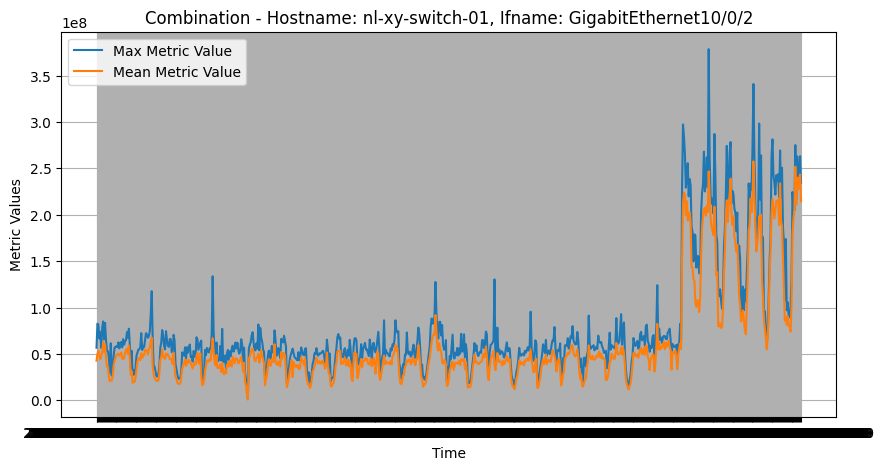

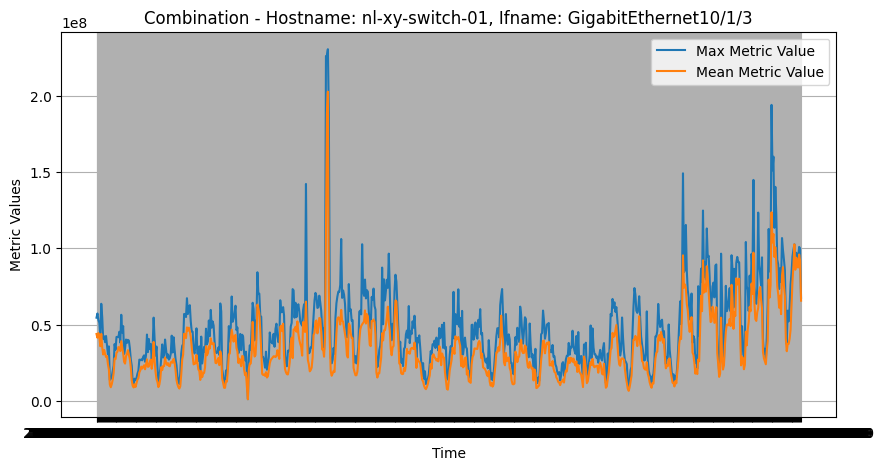

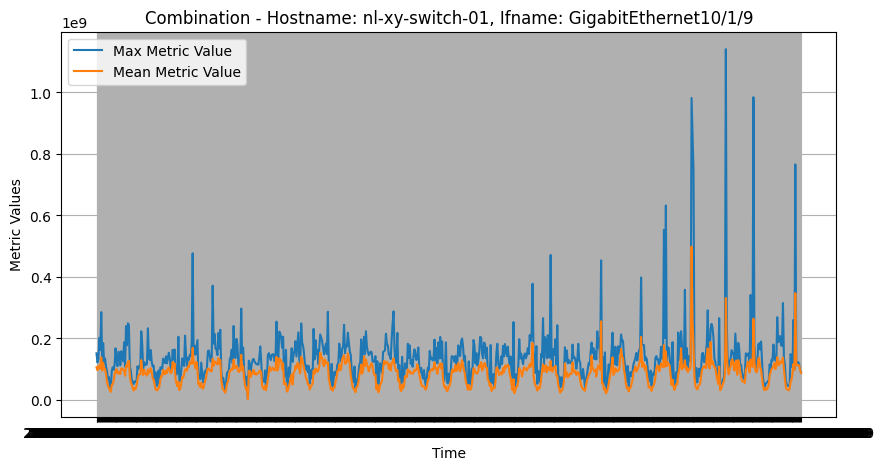

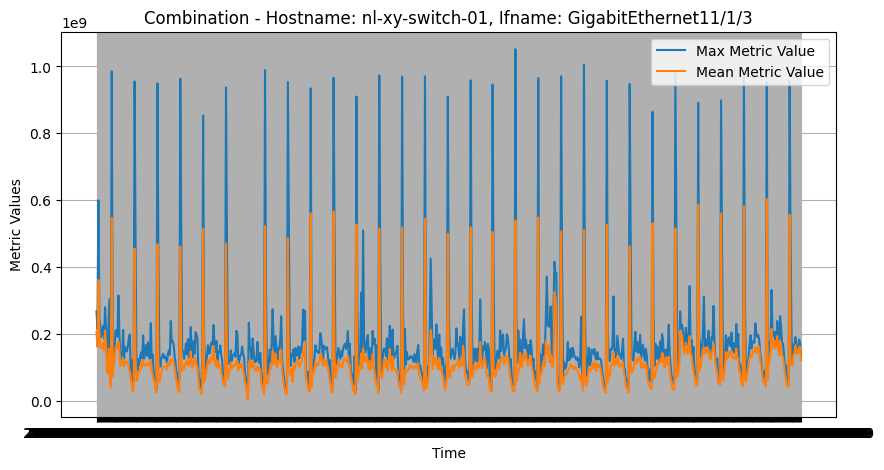

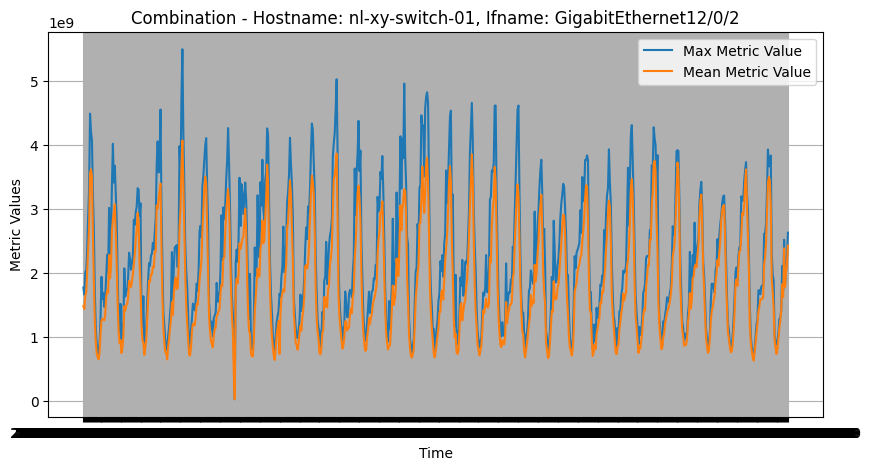

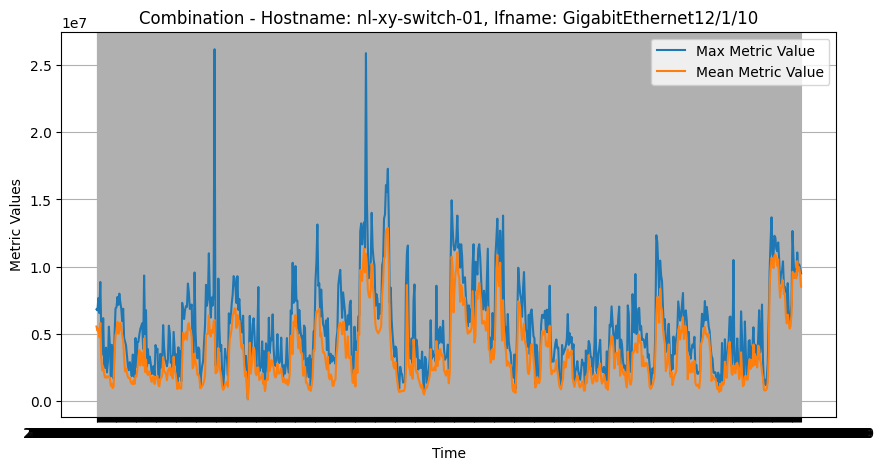

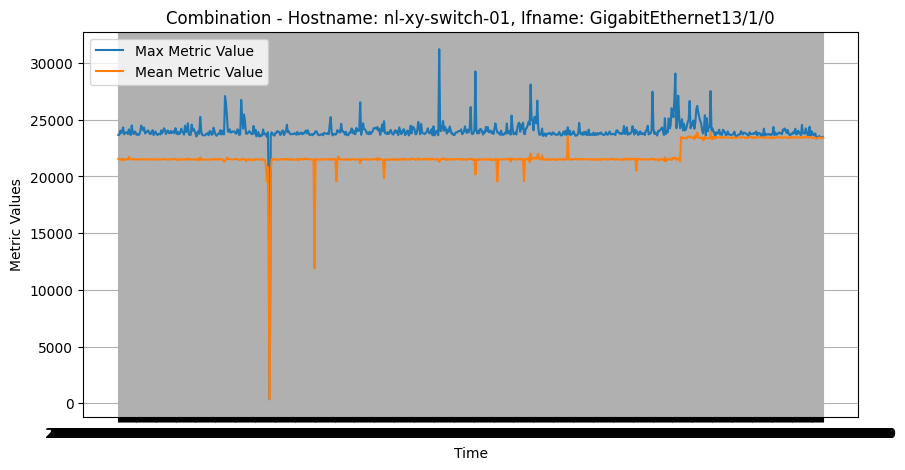

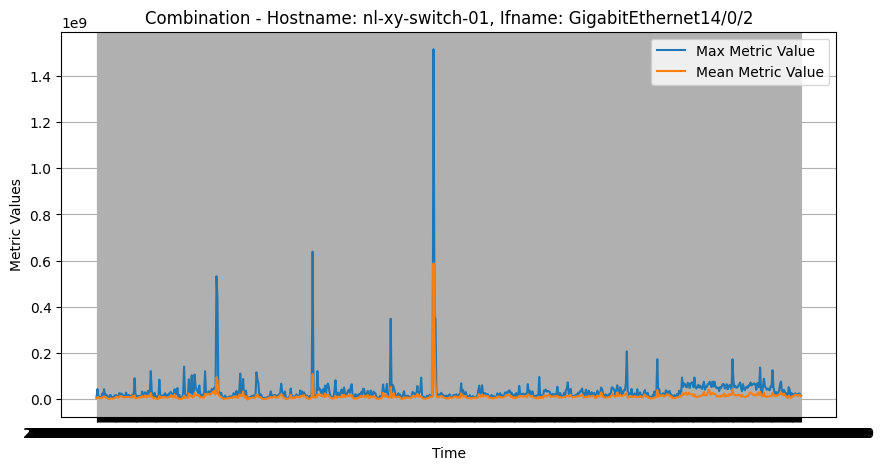

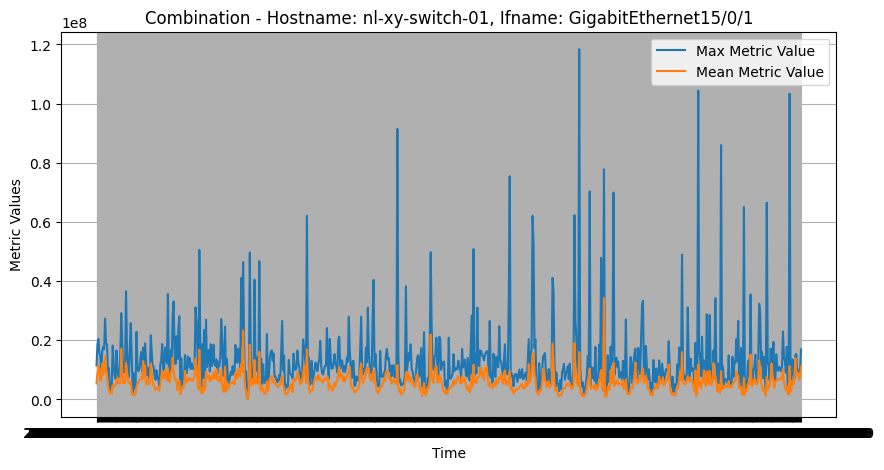

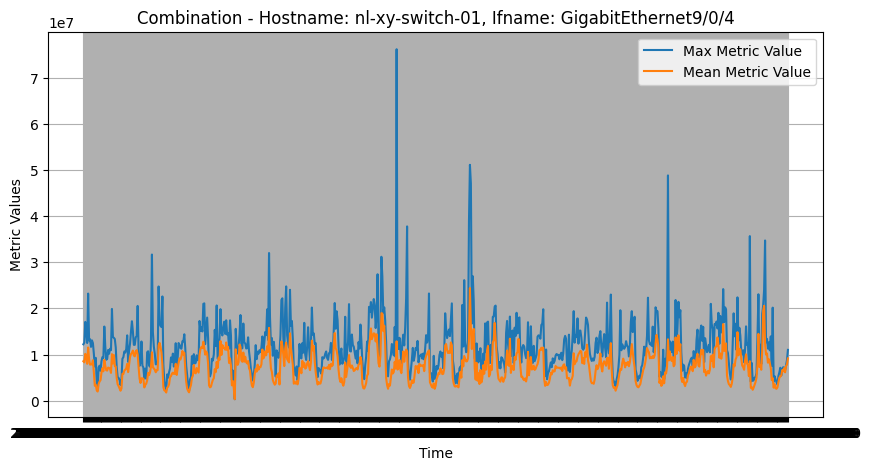

In [15]:
for combination in unique_combinations:

    hostname, ifname = combination
    subset = dataset[(dataset['hostname'] == hostname) & (dataset['ifname'] == ifname)]

    subset = subset.sort_values(by='timeslot')
    time = subset['timeslot']

    plt.figure(figsize=(10, 5))
    plt.plot(time, subset['max_metric_value'], label='Max Metric Value', color='tab:blue')
    plt.plot(time, subset['mean_metric_value'], label='Mean Metric Value', color='tab:orange')
    
    plt.title(f"Combination - Hostname: {hostname}, Ifname: {ifname}")
    plt.xlabel('Time')
    plt.ylabel('Metric Values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
#Getting Nan value rows in the dataset

nan_rows = dataset[dataset.isnull().T.any()]
print(nan_rows)

Empty DataFrame
Columns: [hostname, ifname, timeslot, max_metric_value, mean_metric_value]
Index: []


No NaN rows has been identified and no imputation has to be performed before processing

Plotting Box plots to analyse the data patterns and range.  It also gives a initial understanding of the outlier range present in the data

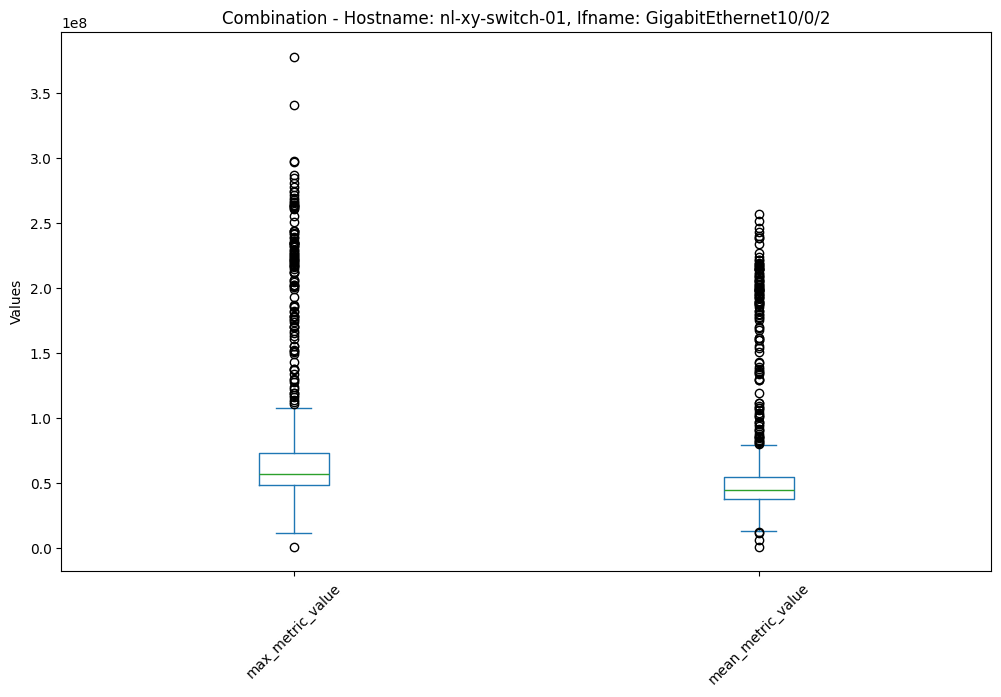

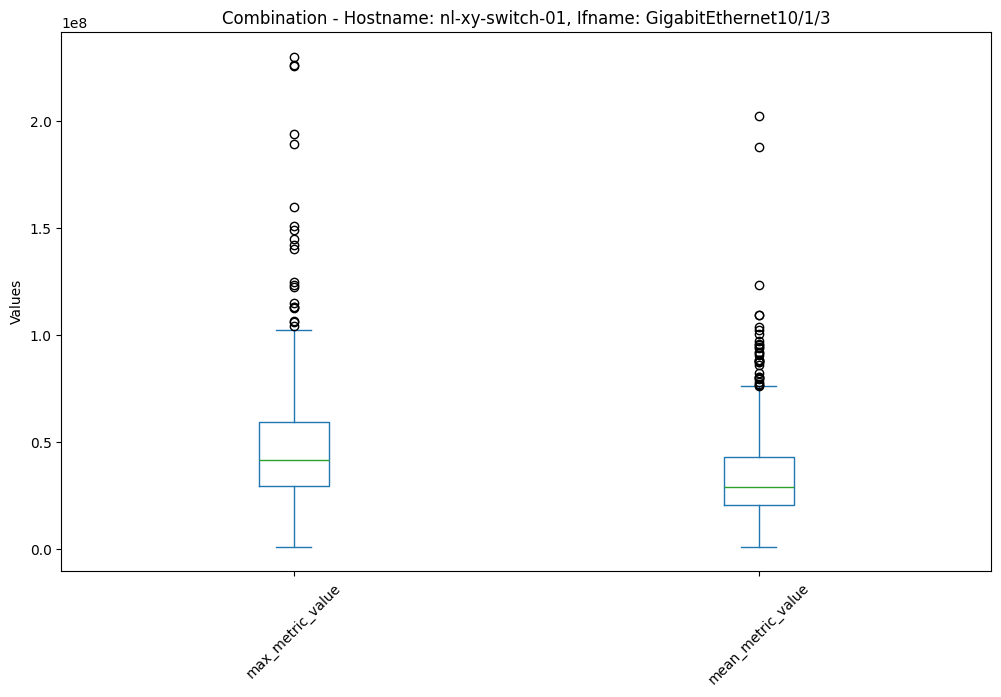

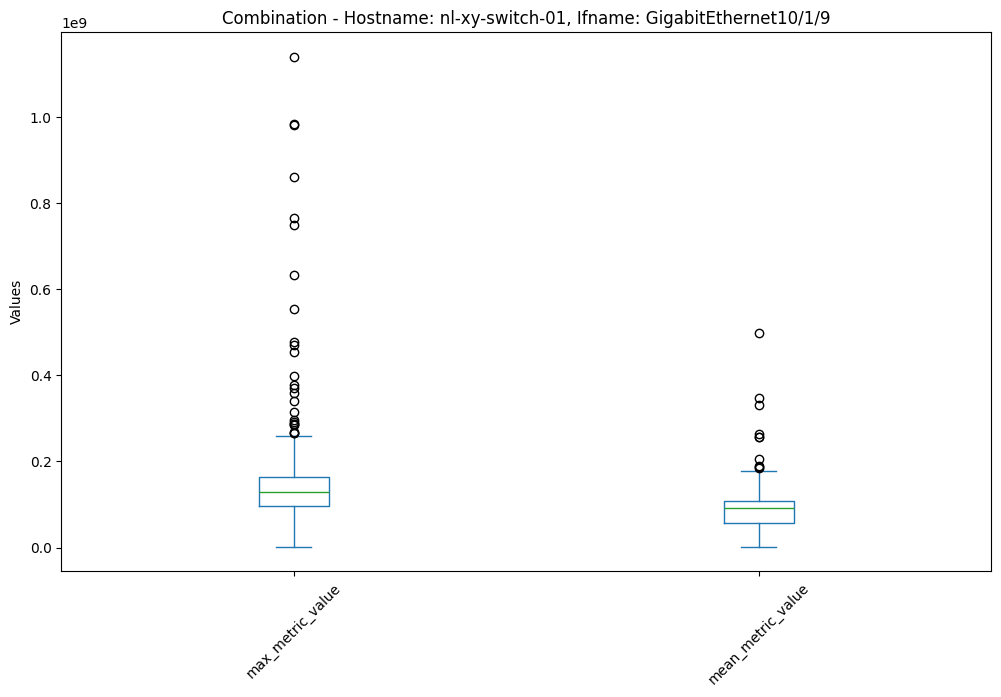

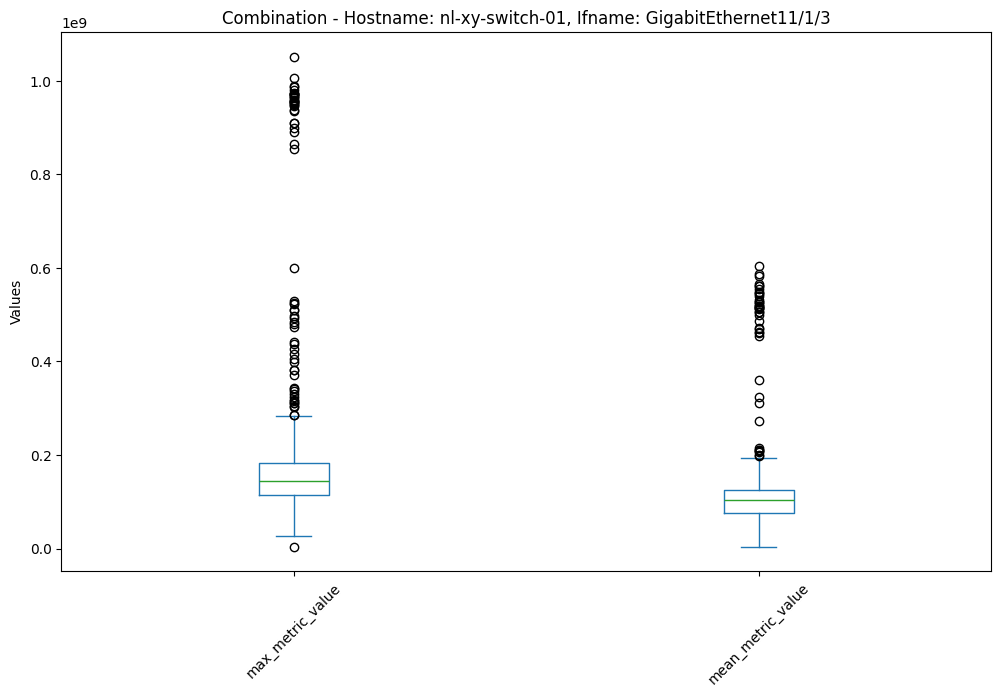

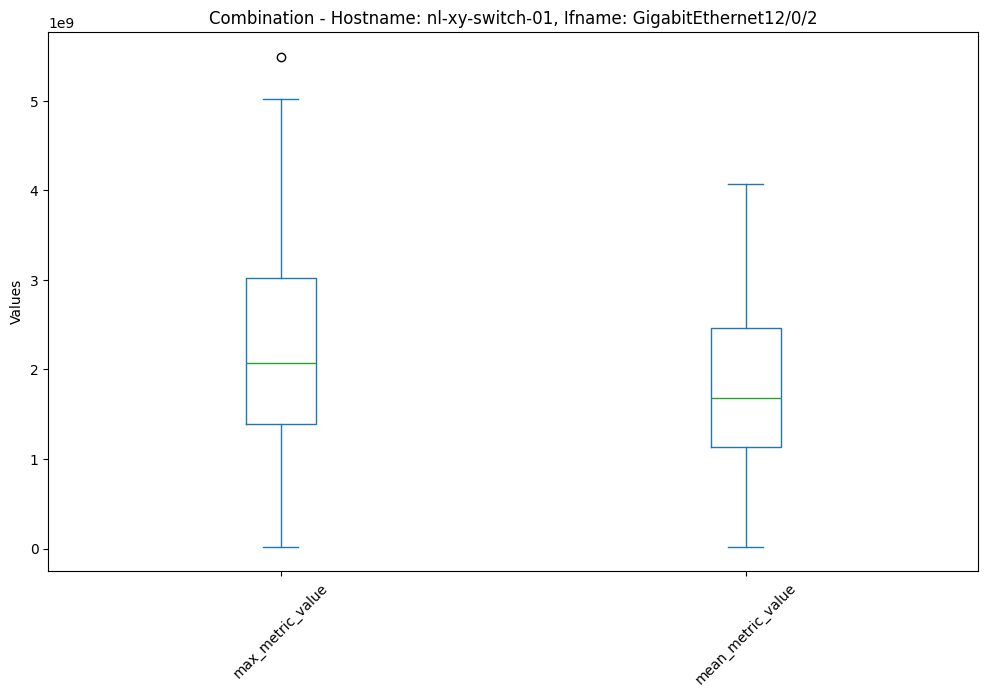

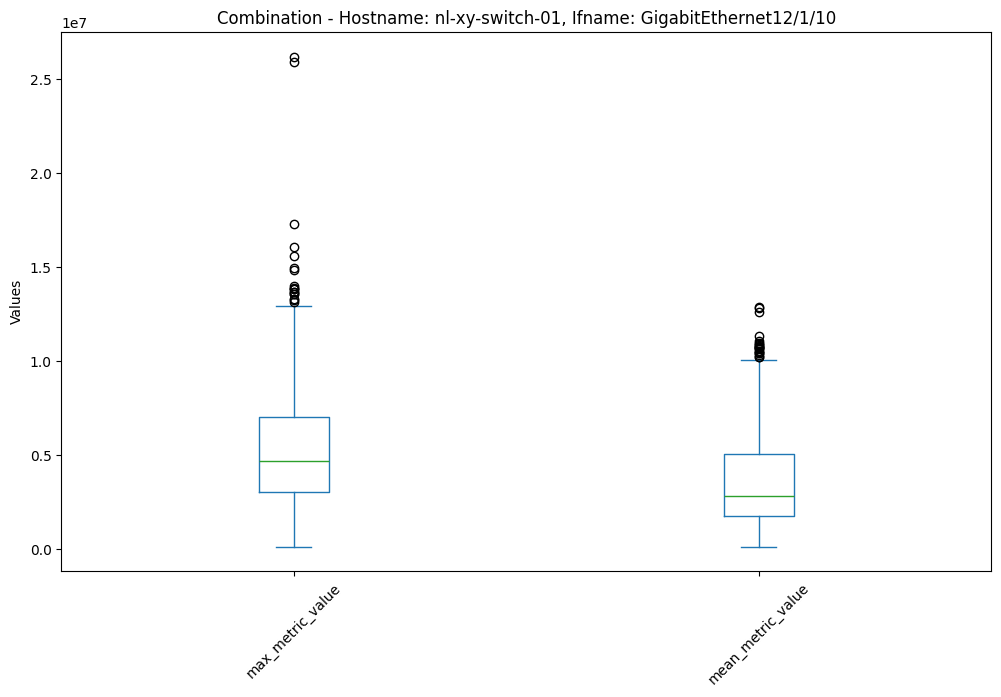

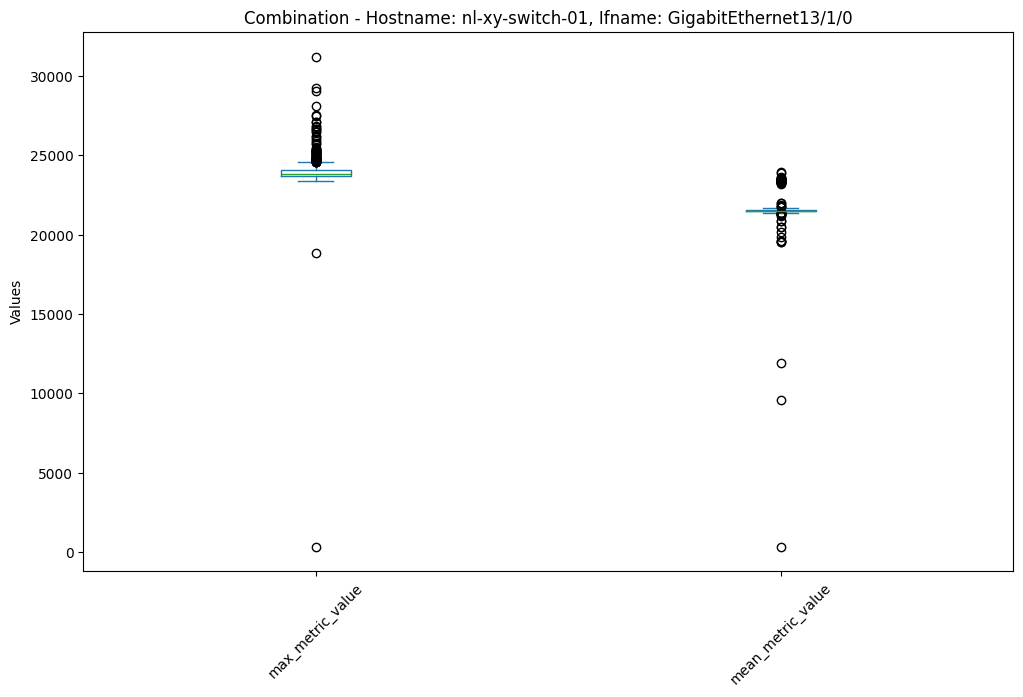

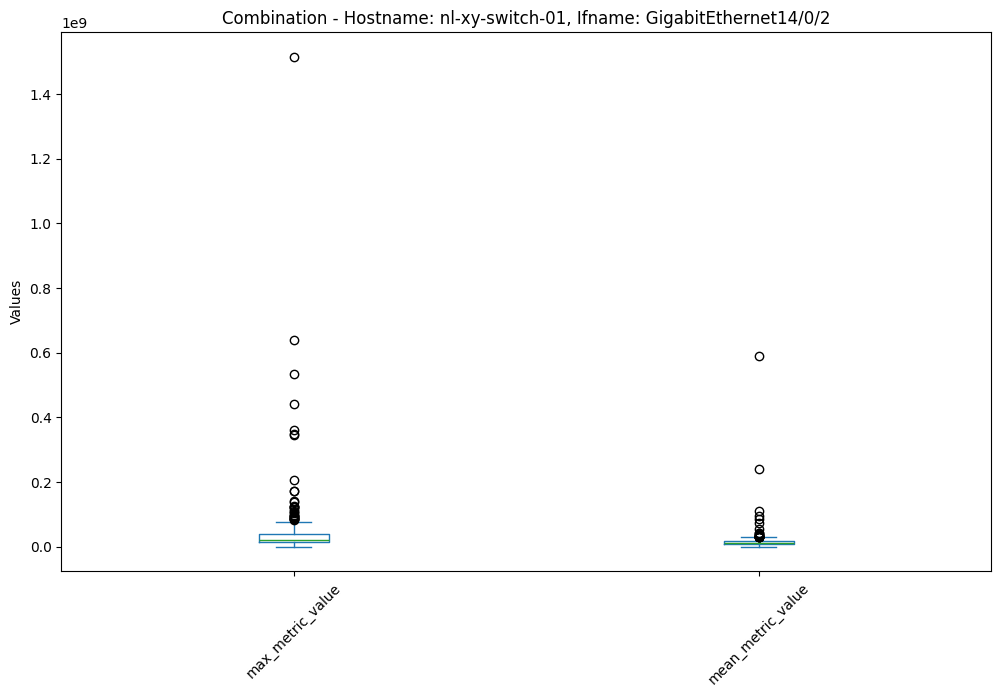

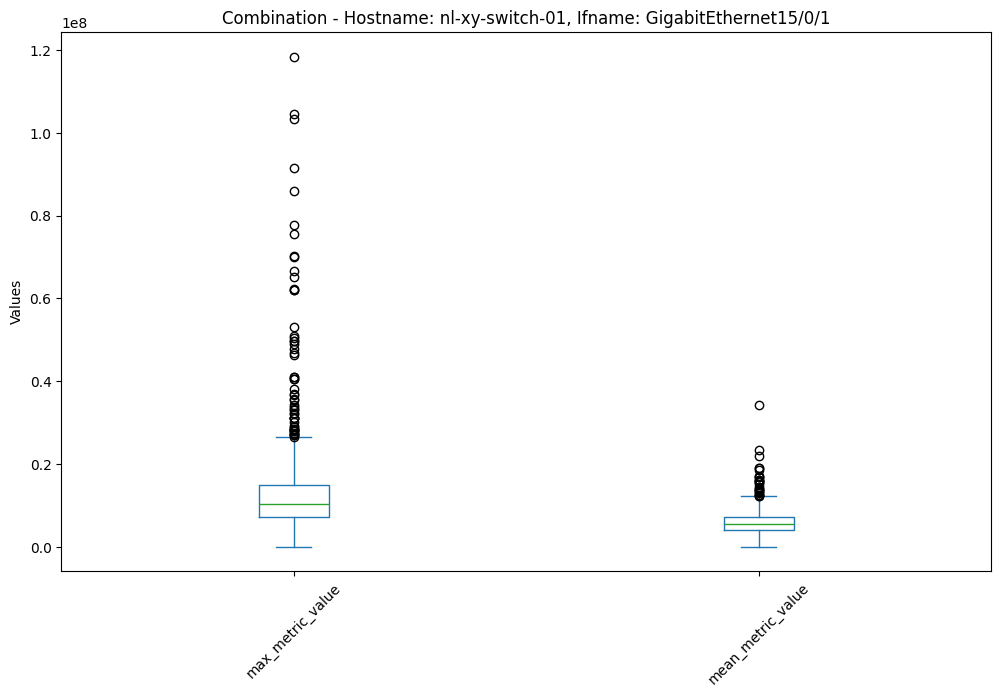

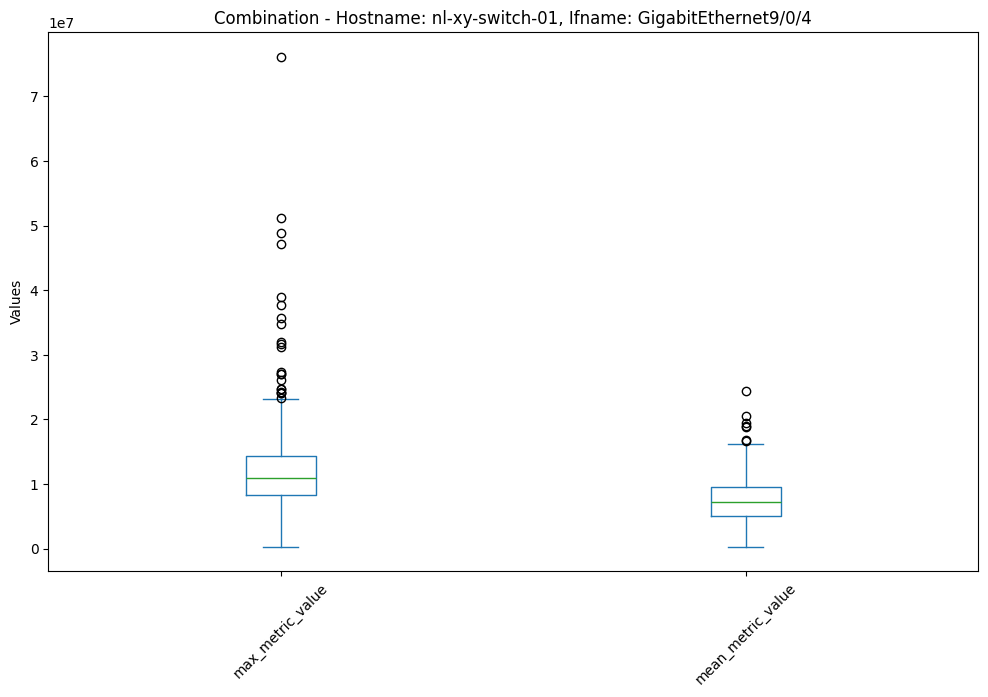

In [17]:
#Checking the presence of outliers in the dataset
for combination in unique_combinations:

    hostname, ifname = combination
    subset = dataset[(dataset['hostname'] == hostname) & (dataset['ifname'] == ifname)]

    fig = subset.plot(kind='box', figsize=(12,7), title='Boxplot - Training Data')
    plt.title(f"Combination - Hostname: {hostname}, Ifname: {ifname}")  # Setting the title for the train data box plot
    plt.ylabel('Values')  # Label for the y-axis
    plt.xticks(rotation=45)  # Optionally rotate x-axis labels if needed
    plt.show()

It can be inferred from the box plot that some routers have more points lying outside the nominal range (for example : ('nl-xy-switch-01', 'GigabitEthernet10/0/2')) and some routers have don't have points that lie outside their nominal range. The higher values also drastically changes for certain routers meaning scaling will be needed to make sure values are normalized and higher values don't dominate during training.

Checking for data distribution to identify if all routers follow a similar distribution or have different patterns

In [25]:
results = []

dataset_distribution = dataset.copy()

dataset_distribution['combination'] = dataset_distribution['hostname'] + ' | ' + dataset_distribution['ifname']

dataset_distribution = dataset_distribution.drop(columns=['timeslot'])

routers = dataset_distribution['combination'].unique()

ks_matrix = pd.DataFrame(index=routers, columns=routers, dtype=float)

for router1, router2 in itertools.combinations(routers, 2):

    subset1 = dataset_distribution[dataset_distribution['combination'] == router1]
    subset2 = dataset_distribution[dataset_distribution['combination'] == router2]

    #KS test for max value
    ks_max = ks_2samp(subset1['max_metric_value'], subset2['max_metric_value'])
    ks_mean = ks_2samp(subset1['mean_metric_value'], subset2['mean_metric_value'])

    ks_matrix.loc[router1, router2] = ks_mean.statistic
    ks_matrix.loc[router2, router1] = ks_mean.statistic

    results.append({
        'Router 1': router1,
        'Router 2': router2,
        'KS Max Statistic': ks_max.statistic,
        'KS Max P-Value': ks_max.pvalue,
        'KS Mean Statistic': ks_mean.statistic,
        'KS Mean P-Value': ks_mean.pvalue
    })

np.fill_diagonal(ks_matrix.values, 0)

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='KS Mean P-Value').tail(5))

                                    Router 1  \
0    nl-xy-switch-01 | GigabitEthernet10/0/2   
37  nl-xy-switch-01 | GigabitEthernet12/1/10   
43   nl-xy-switch-01 | GigabitEthernet14/0/2   
44   nl-xy-switch-01 | GigabitEthernet15/0/1   
17   nl-xy-switch-01 | GigabitEthernet10/1/9   

                                   Router 2  KS Max Statistic  KS Max P-Value  \
0   nl-xy-switch-01 | GigabitEthernet10/1/3          0.379217    7.549072e-48   
37  nl-xy-switch-01 | GigabitEthernet15/0/1          0.534413    3.143167e-97   
43   nl-xy-switch-01 | GigabitEthernet9/0/4          0.484480    3.544183e-79   
44   nl-xy-switch-01 | GigabitEthernet9/0/4          0.093117    3.224688e-03   
17  nl-xy-switch-01 | GigabitEthernet11/1/3          0.144399    3.731776e-07   

    KS Mean Statistic  KS Mean P-Value  
0            0.434548     3.195216e-63  
37           0.402159     6.158846e-54  
43           0.368421     4.033941e-45  
44           0.269906     3.806057e-24  
17           0.1970

Checking KS-Statistic to check if the difference is significance since p-value can flucatuate based on scale

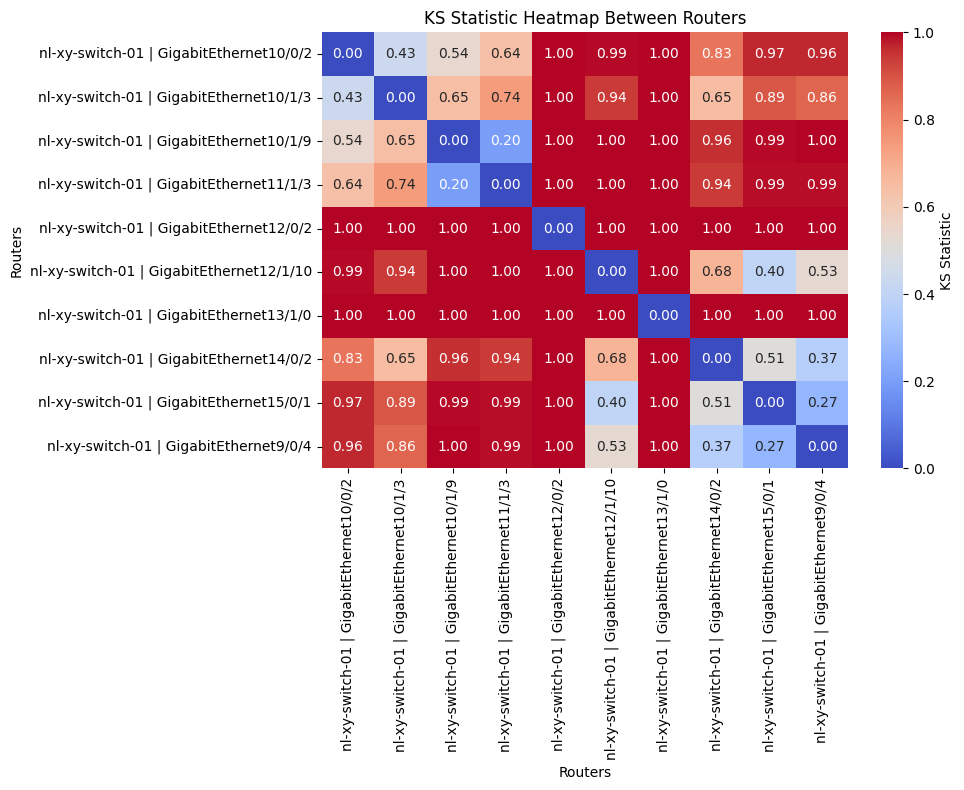

In [27]:
plt.figure(figsize=(10, 8))

sns.heatmap(ks_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'KS Statistic'})

plt.title('KS Statistic Heatmap Between Routers')
plt.xlabel('Routers')
plt.ylabel('Routers')
plt.tight_layout()
plt.show()

Ploting ACF plots to understand the importance of time lagged values

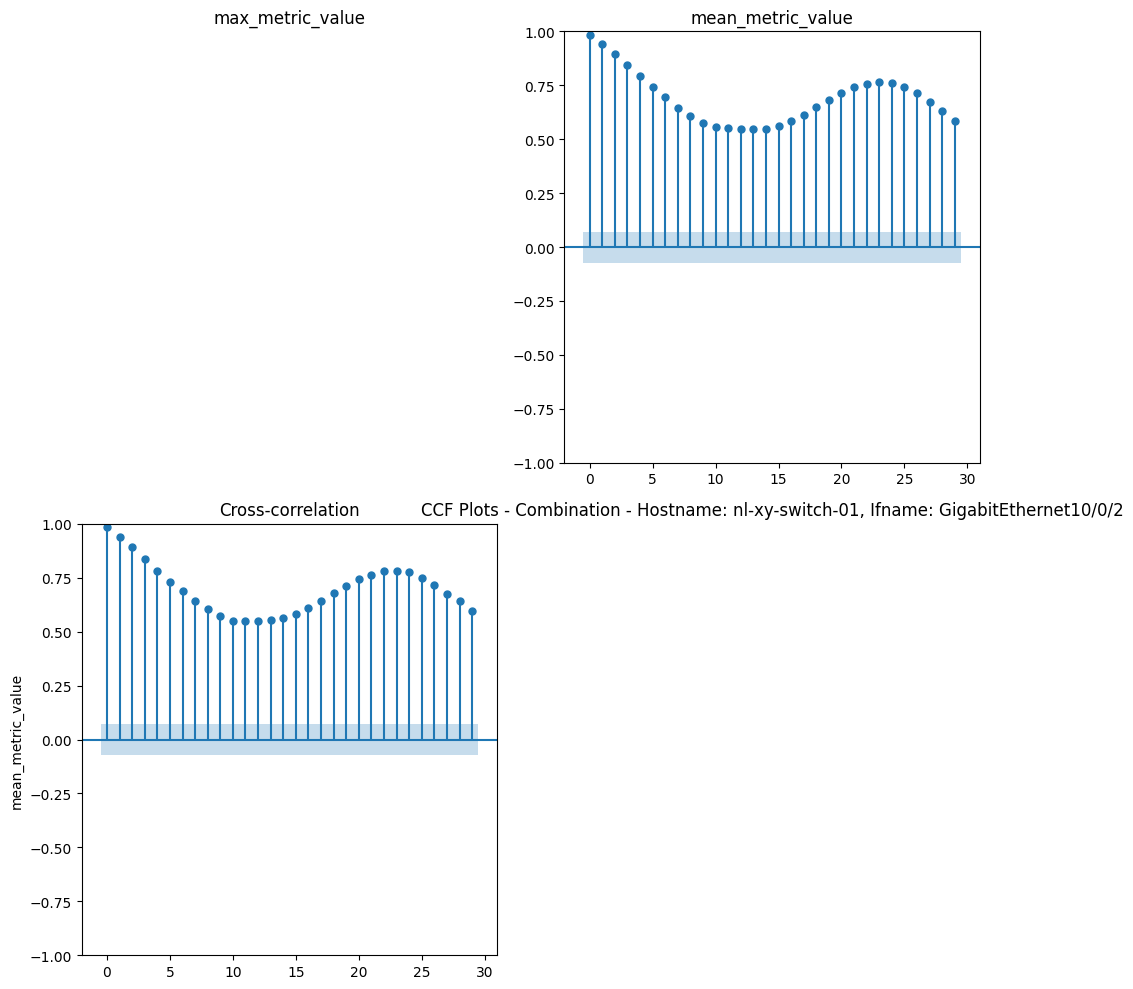

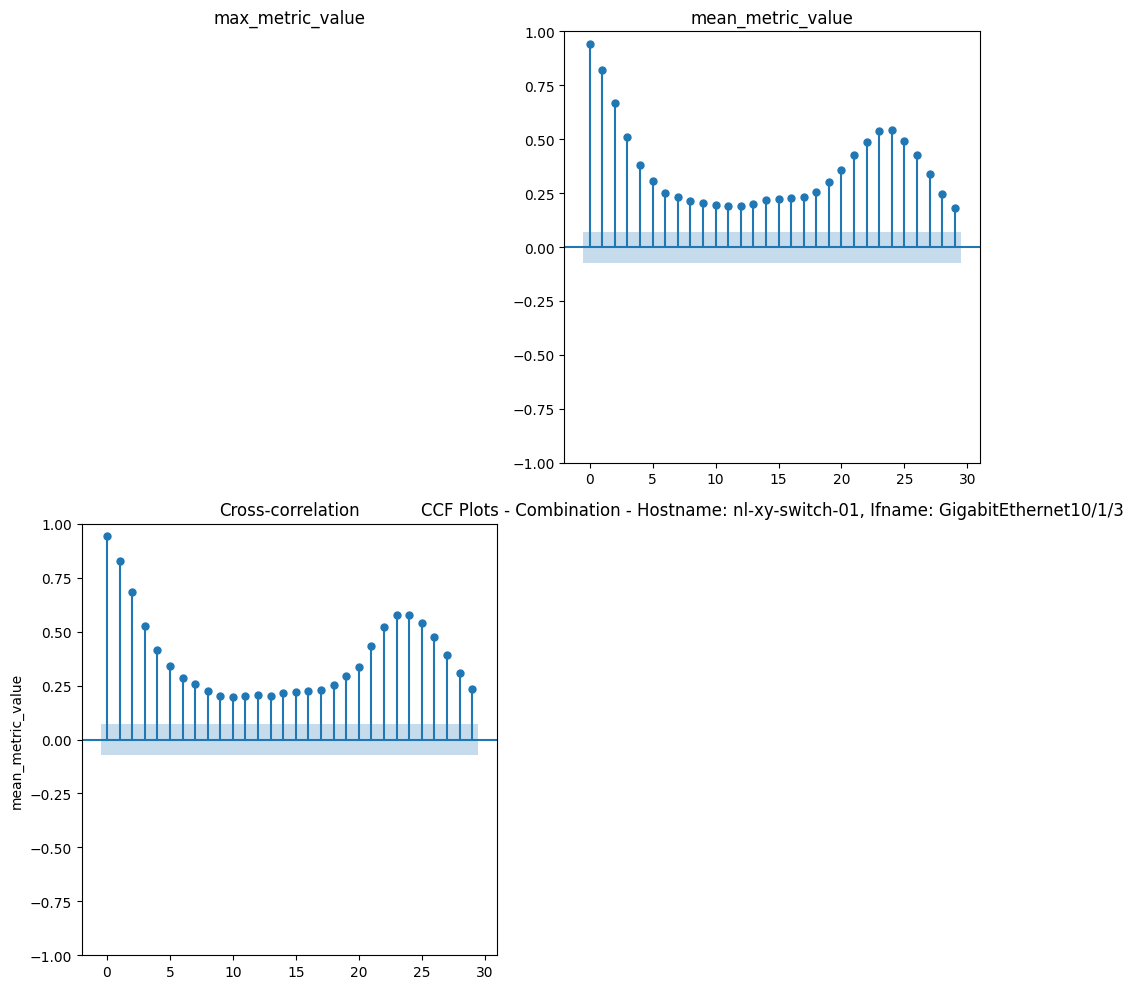

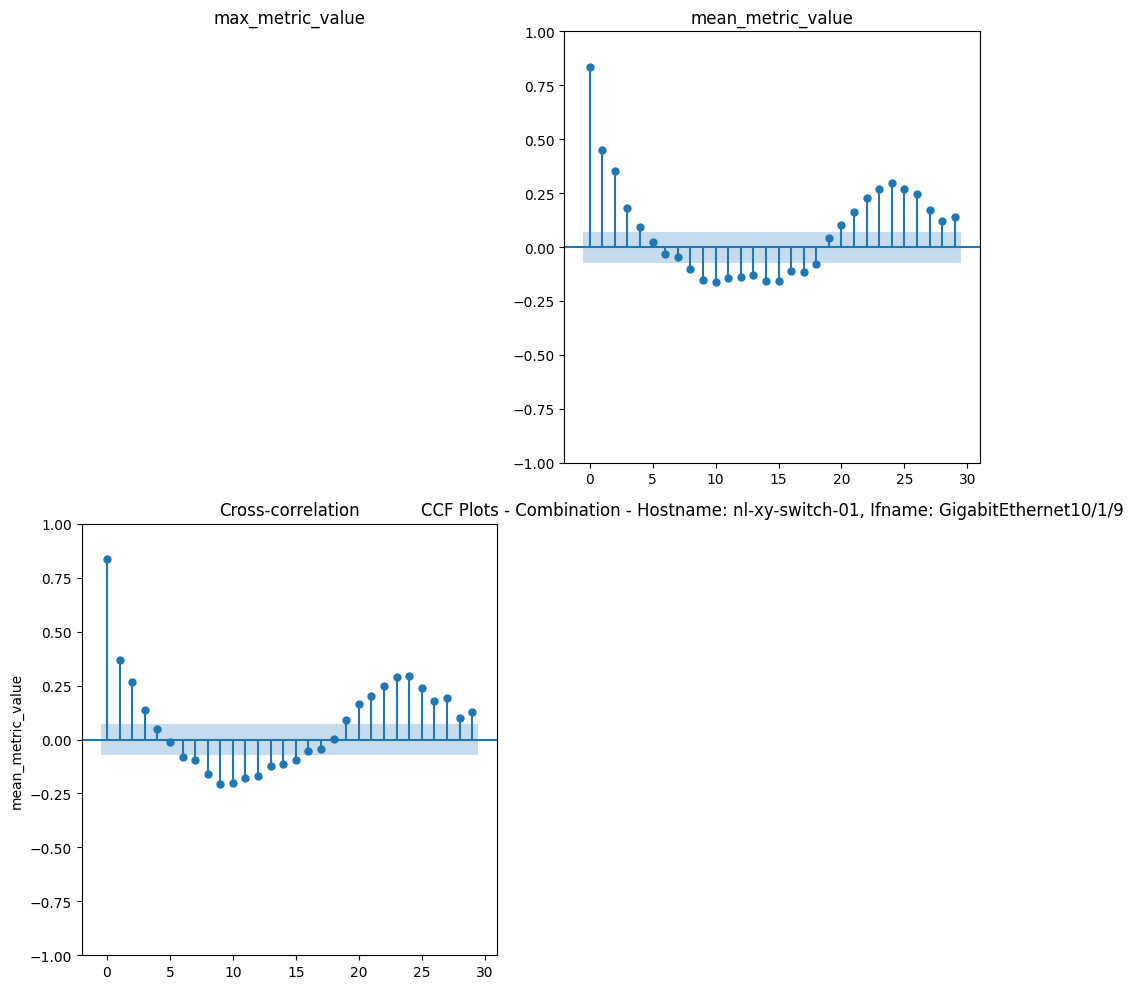

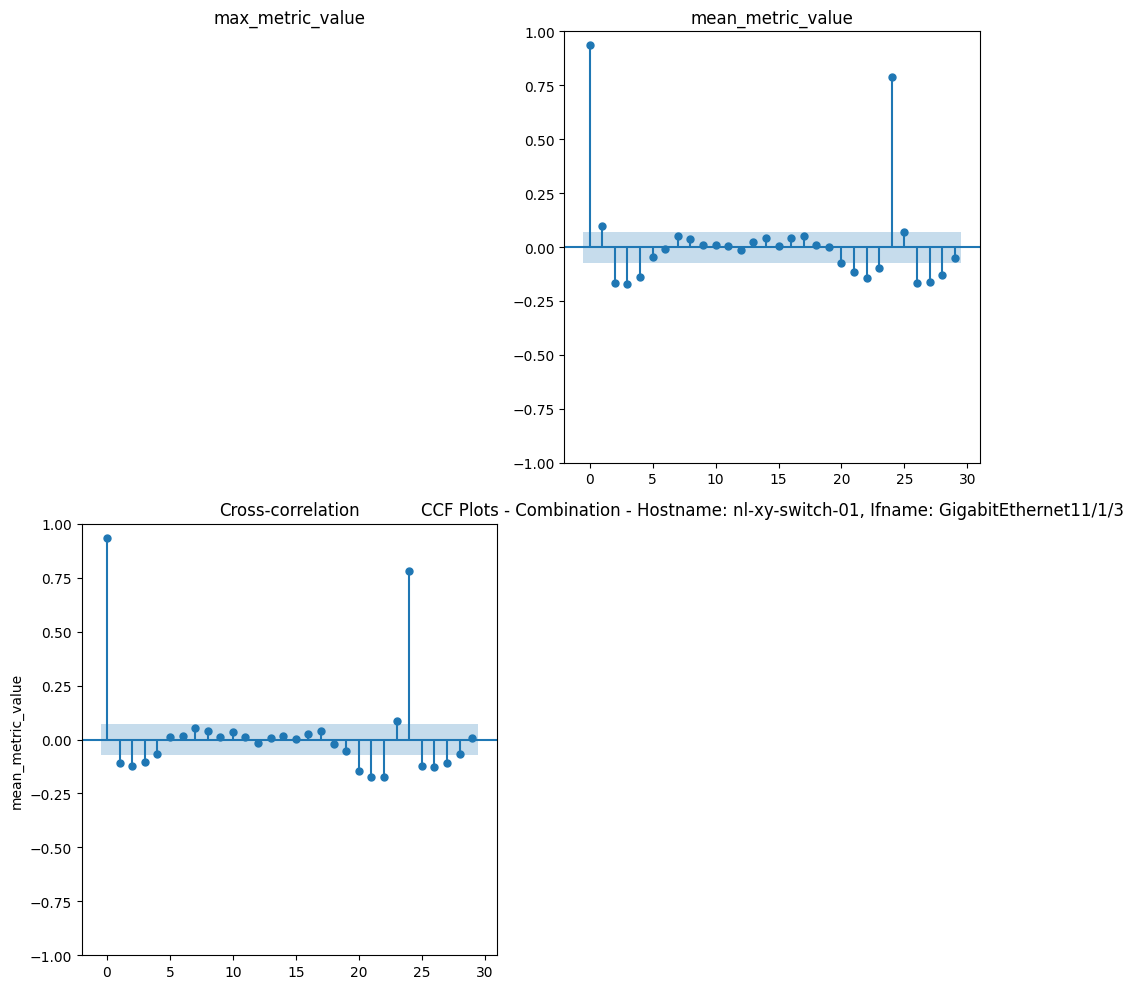

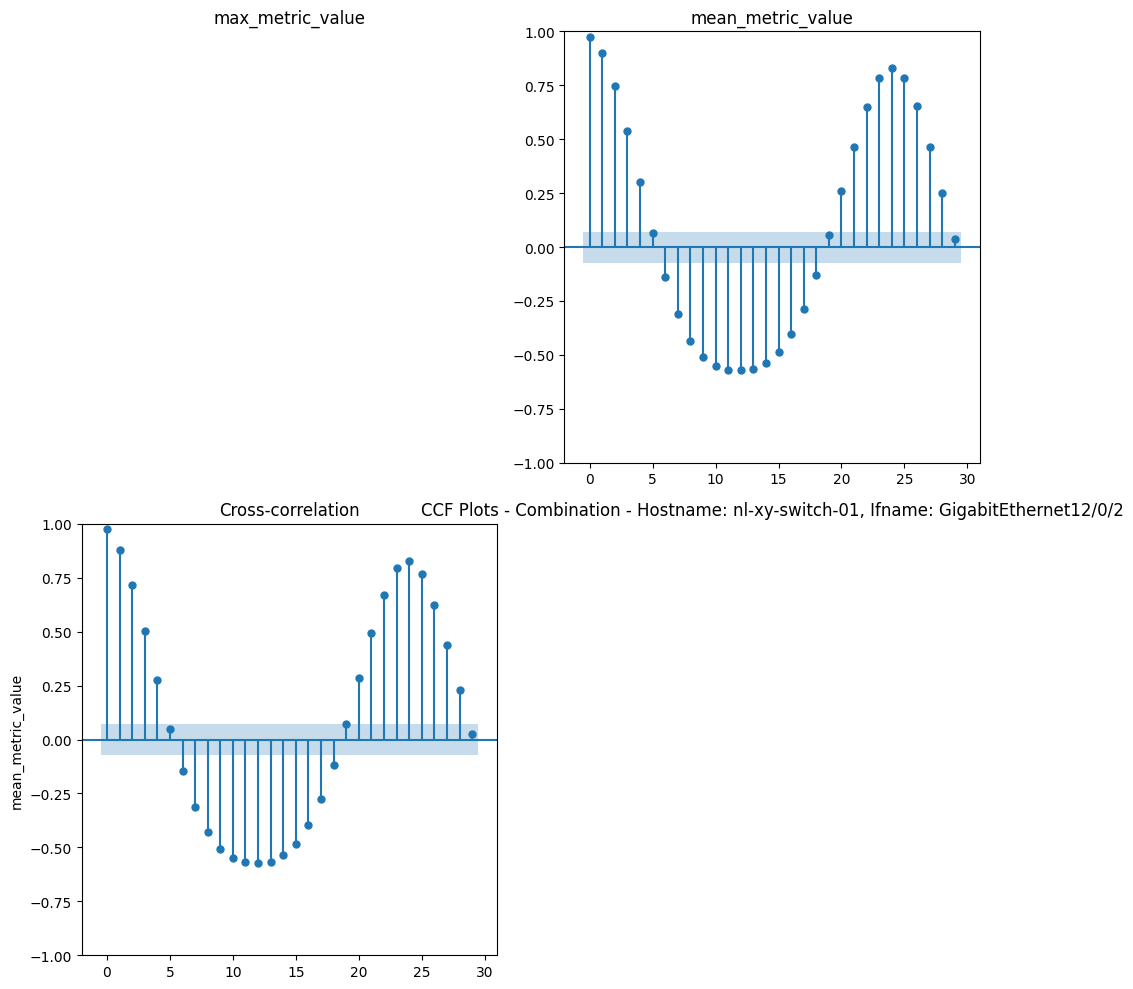

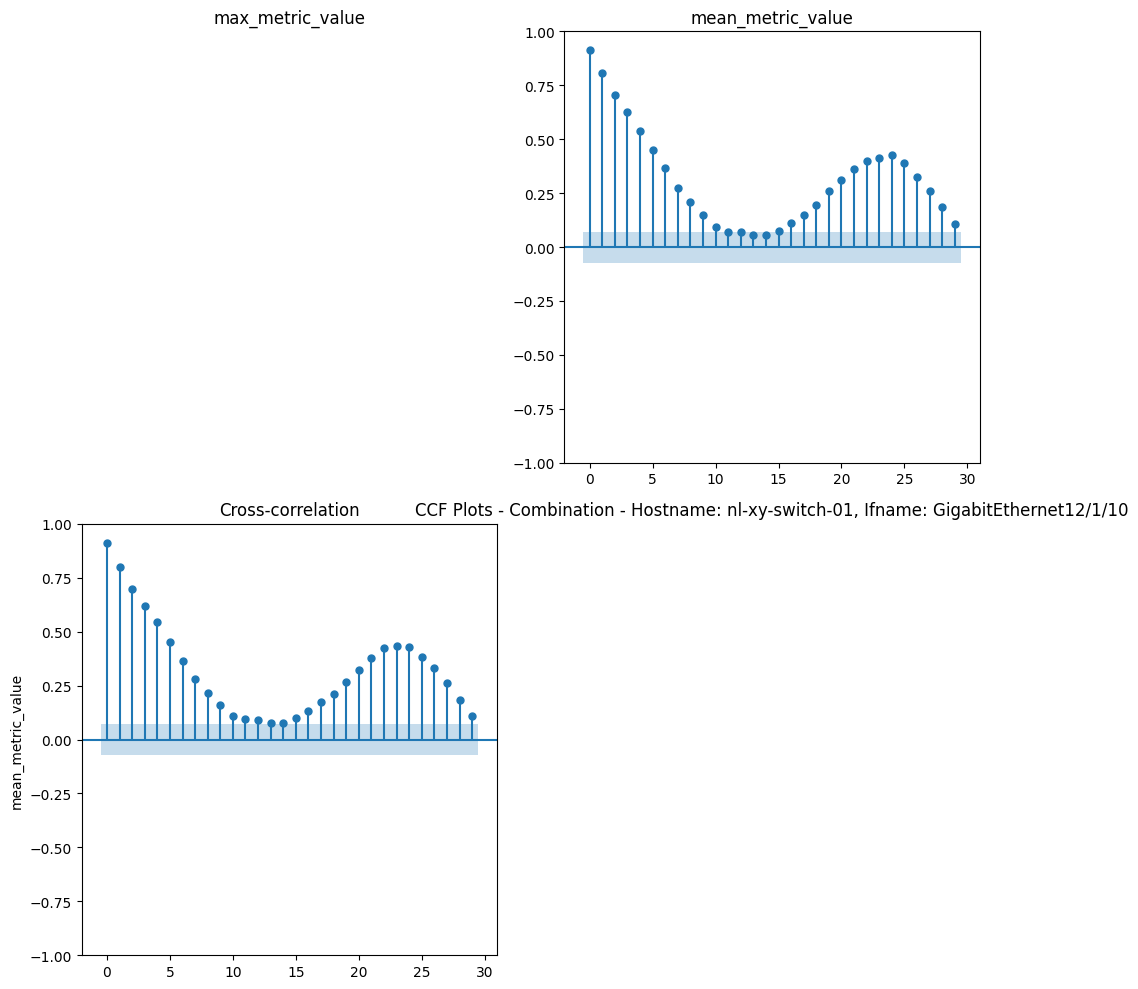

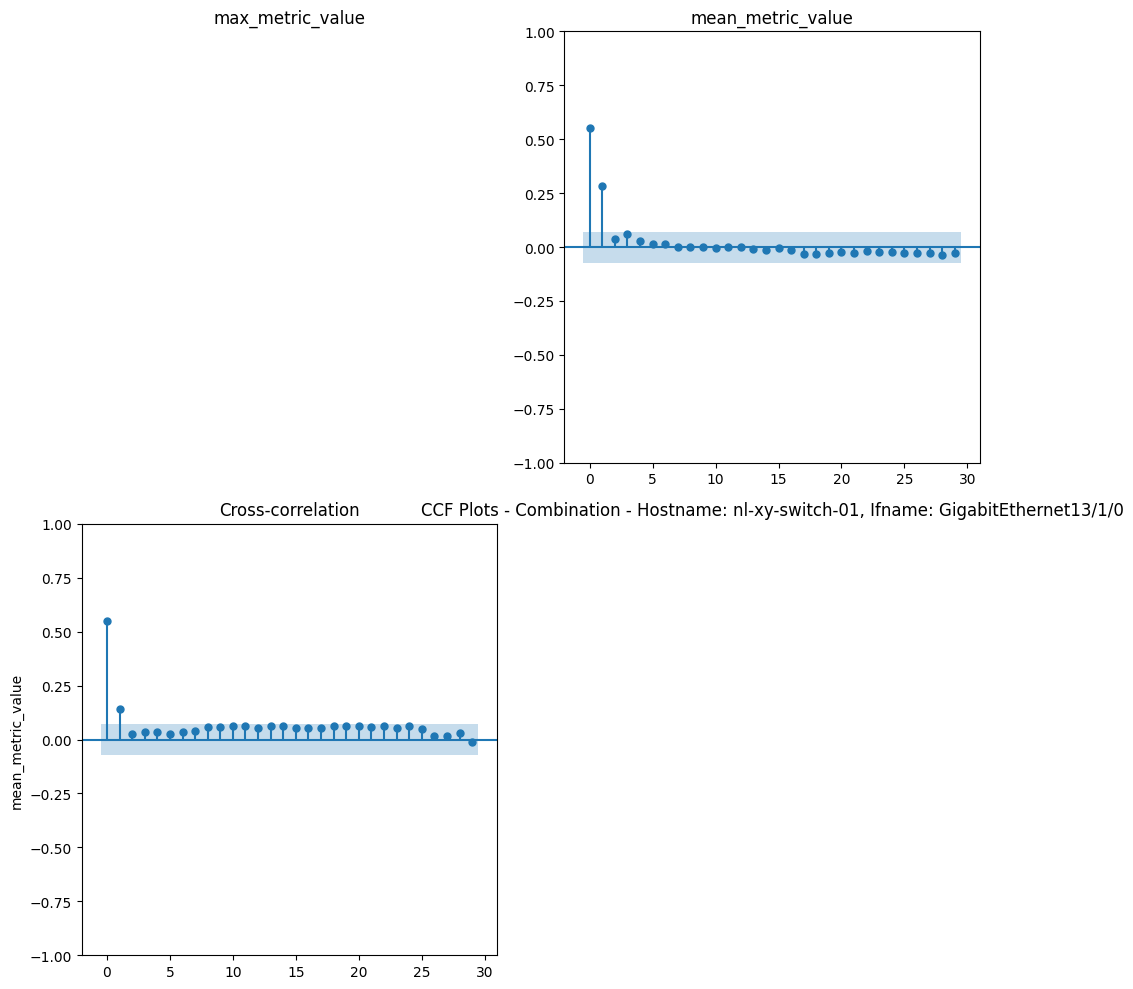

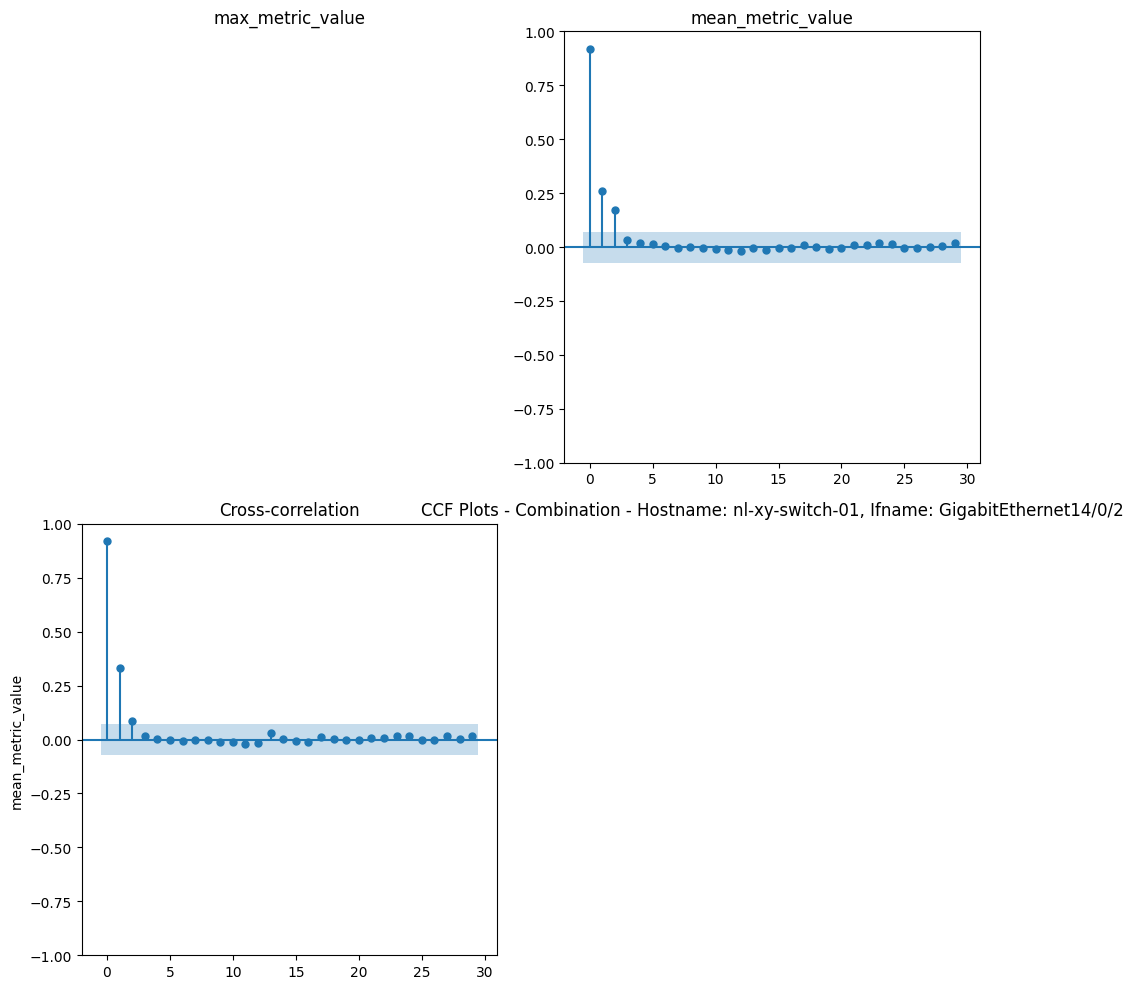

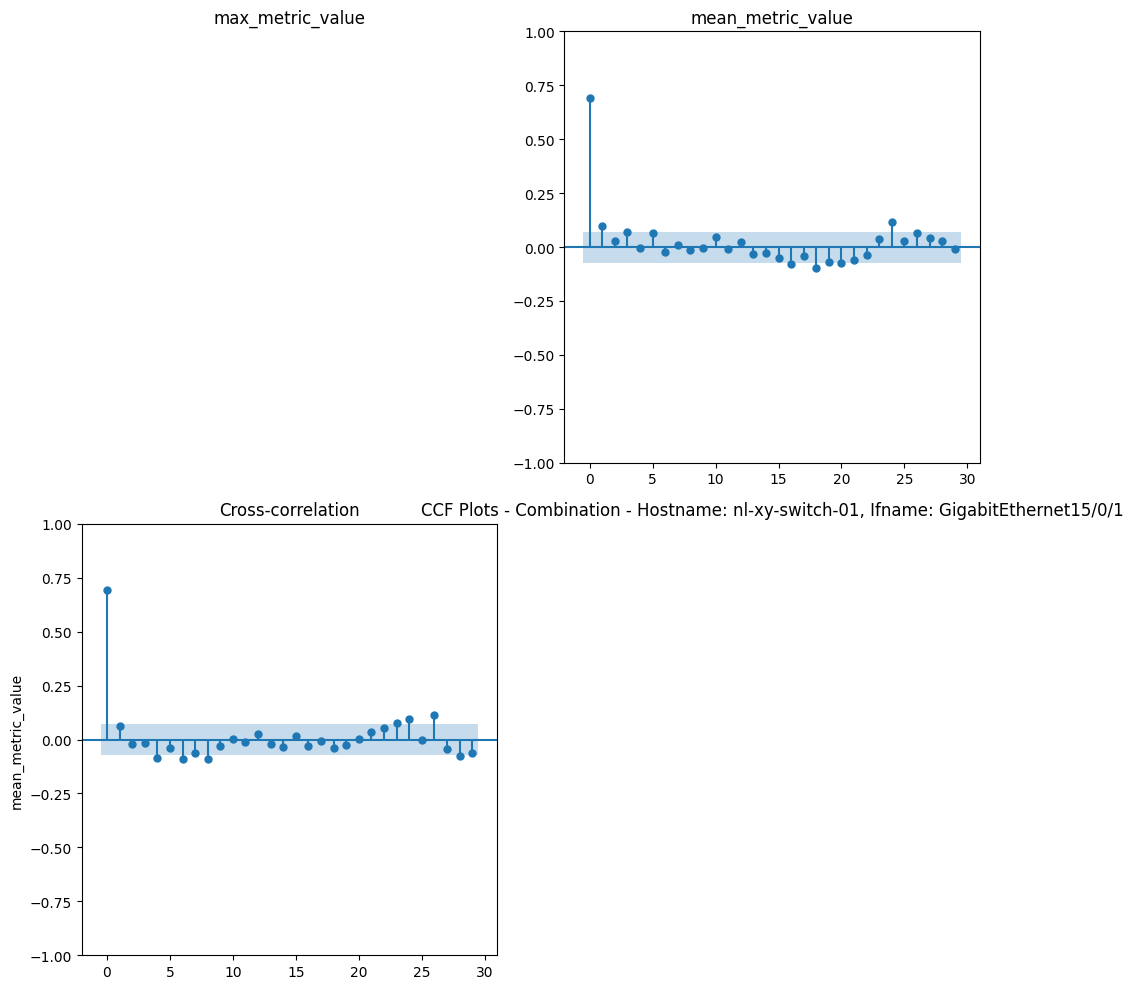

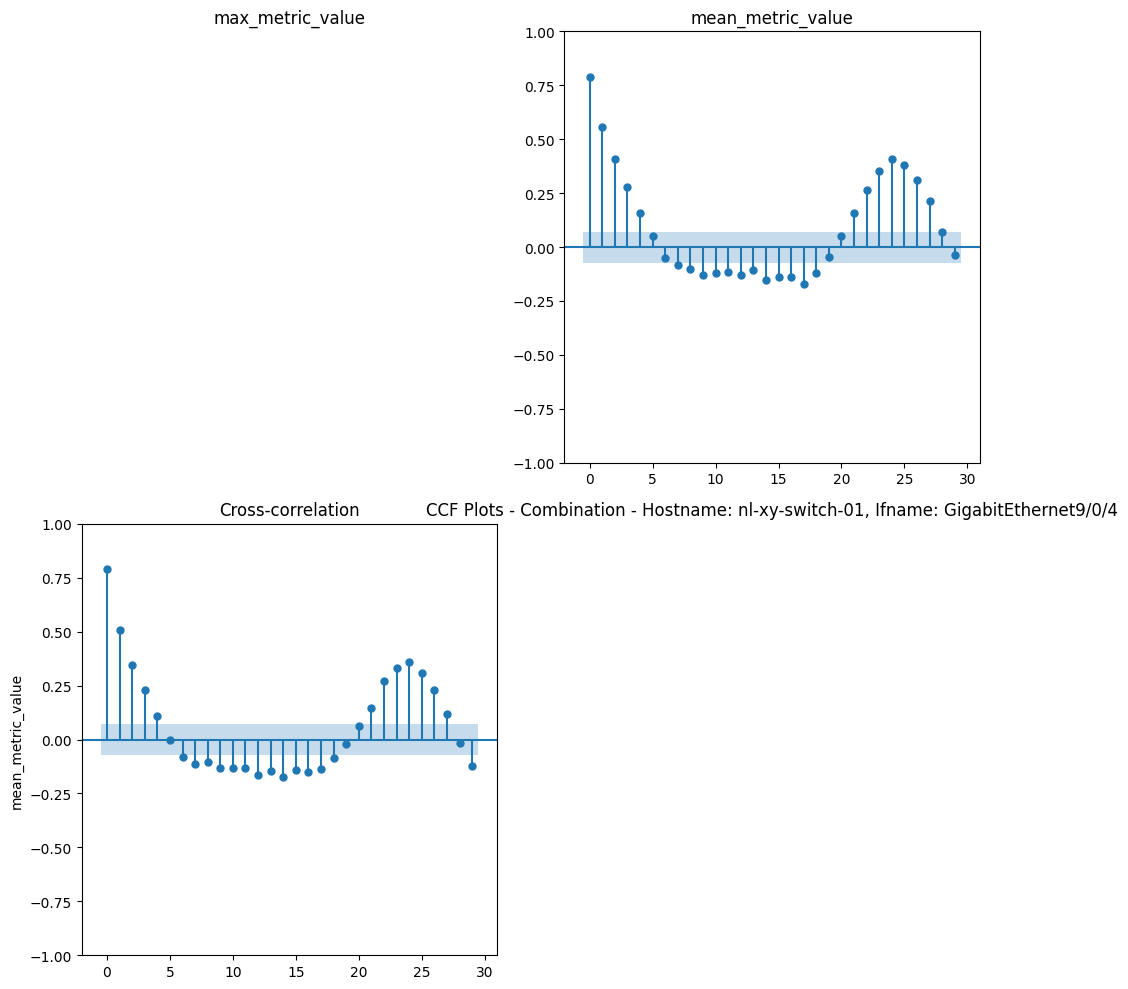

In [38]:
for combination in unique_combinations:

    hostname, ifname = combination
    subset = dataset[(dataset['hostname'] == hostname) & (dataset['ifname'] == ifname)]

        # Get list of column names
    column_names = ['max_metric_value', 'mean_metric_value']

    # Plot CCF for each pair of columns
    num_columns = len(column_names)
    fig, axes = plt.subplots(num_columns, num_columns, figsize=(10, 10))

    for i, col1 in enumerate(column_names):
        for j, col2 in enumerate(column_names):
            ax = axes[i, j]
            if i != j:
                plot_ccf(subset[col1], subset[col2], ax=ax)
            else:
                ax.set_axis_off()
            if i == 0:
                ax.set_title(col2)
            if j == 0:
                ax.set_ylabel(col1)

    plt.title(f"CCF Plots - Combination - Hostname: {hostname}, Ifname: {ifname}")
    plt.tight_layout()
    plt.show()

Using the ACF, we can determine the lagged features to provide as input to the model to learn the pattern. Most routers (8/10) exhibit 24 hour peak meaning the daily pattern remains the same so we can use the window for prediction as 24 hour.